# Generalized Method of Moments (GMM) in R

In [1]:
# load packages
library(tidyverse)
library(haven) # Read and write Stata DTA files
library(gmm) # For gmm
library(nloptr)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: sandwich



## Simple Examples From the Vignettes of gmm Package

* Refer to https://cran.r-project.org/web/packages/gmm/vignettes/gmm_with_R.pdf

In [2]:
# Simulate One column data

# Reproducible
set.seed(123)
# Generate the data from normal distribution
n <- 200
x <- rnorm(n, mean = 4, sd = 2)

In [3]:
# set up the moment conditions for comparison

# MM (just identified)
g0 <- function(tet, x) {
  m1 <- (tet[1] - x)
  m2 <- (tet[2]^2 - (x - tet[1])^2)
  f <- cbind(m1, m2)
  return(f)
}

# GMM (over identified)
g1 <- function(tet, x) {
  m1 <- (tet[1] - x)
  m2 <- (tet[2]^2 - (x - tet[1])^2)
  m3 <- x^3 - tet[1] * (tet[1]^2 + 3 * tet[2]^2)
  f <- cbind(m1, m2, m3)
  return(f)
}

In [4]:
print(res0 <- gmm(g0, x, c(mu = 0, sig = 0)))

Method
 twoStep 

Objective function value:  3.513133e-06 

    mu     sig  
3.9812  1.8814  

Convergence code =  0 


In [5]:
print(res1 <- gmm(g1, x, c(mu = 0, sig = 0)))

Method
 twoStep 

Objective function value:  0.01307637 

    mu     sig  
3.8939  1.7867  

Convergence code =  0 


In [6]:
summary(res0)


Call:
gmm(g = g0, x = x, t0 = c(mu = 0, sig = 0))


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
     Estimate     Std. Error   t value      Pr(>|t|)   
mu    3.9812e+00   1.2373e-01   3.2177e+01  3.7093e-227
sig   1.8814e+00   9.9904e-02   1.8832e+01   4.1605e-79

J-Test: degrees of freedom is 0 
                J-test                P-value             
Test E(g)=0:    0.000702626643691055  *******             

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  67 
Gradian eval. =  NA 

In [7]:
summary(res1)


Call:
gmm(g = g1, x = x, t0 = c(mu = 0, sig = 0))


Method:  twoStep 

Kernel:  Quadratic Spectral(with bw =  0.71322 )

Coefficients:
     Estimate     Std. Error   t value      Pr(>|t|)   
mu    3.8939e+00   1.2032e-01   3.2364e+01  8.9213e-230
sig   1.7867e+00   8.3472e-02   2.1405e+01  1.1937e-101

J-Test: degrees of freedom is 1 
                J-test   P-value
Test E(g)=0:    2.61527  0.10584

Initial values of the coefficients
      mu      sig 
4.022499 1.881766 

#############
Information related to the numerical optimization
Convergence code =  0 
Function eval. =  63 
Gradian eval. =  NA 

## More realistic example


* The relationship between research and development expenditures of firms and the number of patents applied and received by them has received substantial attention in the literature; see Hausman, Hall and Griliches (1984).

In [8]:
# Read the .dta
# read_dta() is in the package of `haven`, which is also part of tidyverse
# However, `haven` is not automaticcally loaded when loading tidyverse
# We need to load `haven` explicitly.

patents_df <- read_dta("patents.dta")
# explore
glimpse(patents_df)

Rows: 181
Columns: 11
$ p91      <dbl> 55, 67, 55, 83, 0, 4, 7, 0, 0, 96, 11, 39, 2, 13, 1, 42, 1, 1…
$ p90      <dbl> 80, 46, 42, 102, 1, 11, 55, 0, 1, 67, 11, 39, 3, 14, 6, 33, 1…
$ lr91     <dbl> 6.287436, 5.150736, 4.172709, 6.127538, 4.866621, 7.696947, 5…
$ lr90     <dbl> 6.16, 5.14, 4.10, 6.15, 4.82, 7.53, 5.88, 5.22, 5.56, 5.89, 5…
$ aerosp   <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ chemist  <dbl> 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1…
$ computer <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0…
$ machines <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ vehicles <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ japan    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ us       <dbl> 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0…


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



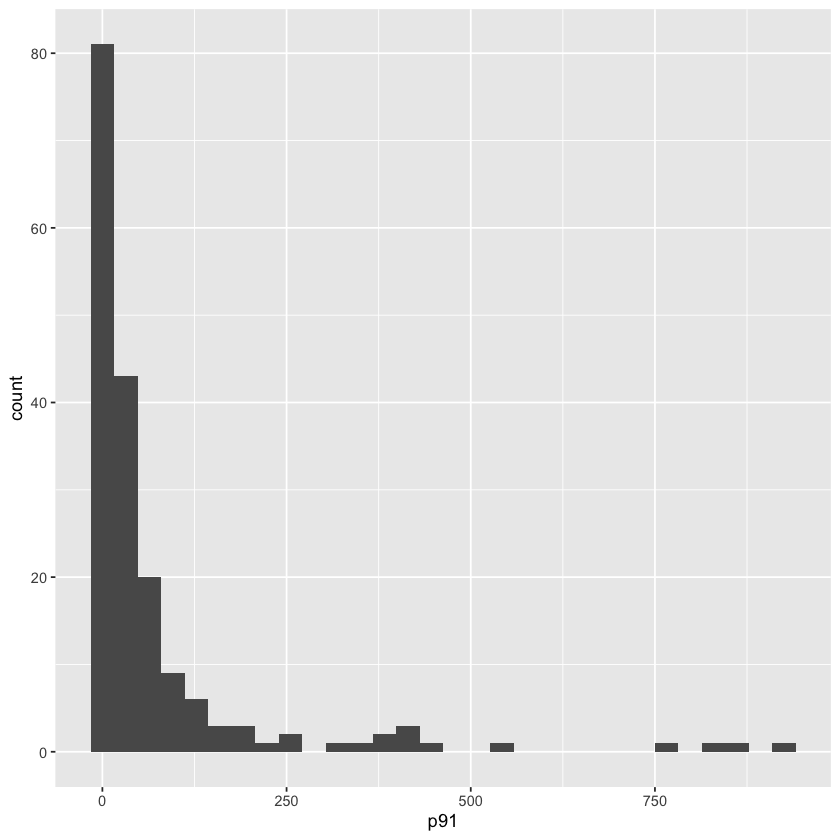

In [9]:
patents_df %>%
  ggplot(aes(p91)) %>%
  +geom_histogram()

In [10]:
# Poisson (variance equals mean) with Default standard errors based on the
# inverse of the Hessian of log like function

poisson_res <- patents_df %>%
  glm(p91 ~ lr91 + aerosp + chemist + computer + machines +
    vehicles + japan + us, family = poisson(), data = .)

summary(poisson_res)


Call:
glm(formula = p91 ~ lr91 + aerosp + chemist + computer + machines + 
    vehicles + japan + us, family = poisson(), data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-27.979   -5.246   -1.572    2.352   29.246  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.873731   0.065868  -13.27  < 2e-16 ***
lr91         0.854525   0.008387  101.89  < 2e-16 ***
aerosp      -1.421850   0.095640  -14.87  < 2e-16 ***
chemist      0.636267   0.025527   24.93  < 2e-16 ***
computer     0.595343   0.023338   25.51  < 2e-16 ***
machines     0.688953   0.038346   17.97  < 2e-16 ***
vehicles    -1.529653   0.041864  -36.54  < 2e-16 ***
japan        0.222222   0.027502    8.08 6.46e-16 ***
us          -0.299507   0.025300  -11.84  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 29669.4  on 180  degrees of freedom
Residual deviance:

In [11]:
# GMM estimator as Quasi- (Psudo-) MLE
# Define moment conditions matrix for QMLE (gmm)

mom <- function(beta, df) {
  # df is the data frame with first column as dv
  # This function returns n * q matrix
  # Each column is one moment condition before taking sample average
  # There are totally q moment conditions

  y <- as.numeric(df[, 1])
  x <- data.matrix(df[, 2:ncol(df)])

  # Refer to moment conditions of QMLE
  m <- x * as.vector(y - exp(x %*% beta))

  return(cbind(m))
}

In [12]:
# Generate the data with all needed variables only
df_n <- patents_df %>%
  select(
    p91, lr91, aerosp, chemist, computer, machines,
    vehicles, japan, us
  ) %>%
  mutate(const = 1) %>%
  # Please hold the order as previous glm() to facilitate comparison
  select(
    p91, const, lr91, aerosp, chemist, computer, machines,
    vehicles, japan, us
  )

## Need to converse the tibble class to dataframe
df_n <- as.data.frame(df_n)

In [13]:
# Generate regression coef as the initial values for QMLE (gmm)
init_values <- patents_df %>%
  select(
    p91, lr91, aerosp, chemist, computer, machines,
    vehicles, japan, us
  ) %>%
  mutate(const = 1) %>%
  # Please hold the order as previous glm() to facilitate comparison
  select(
    p91, const, lr91, aerosp, chemist, computer, machines,
    vehicles, japan, us
  ) %>%
  lm(p91 ~ lr91 + aerosp + chemist + computer + machines +
    vehicles + japan + us, data = .) |>
  {\(x) coef(x)*0.01}()

* Several issues about the config need to be careful when using `gmm()` function
    * `wmatrix` should be set `"optimal"` (by default) whenever possible such that the optimal weights are used for efficiency. For the efficiency please check **13.8 EfficientGMM** in [Econometrics](https://www.ssc.wisc.edu/~bhansen/econometrics/Econometrics.pdf). At the same time, two-step estimation will be applied accordingly to employ the consistent estimate of the weights. Please check Page 151 of [A Guide to Modern Econometrics](https://thenigerianprofessionalaccountant.files.wordpress.com/2013/04/modern-econometrics.pdf)
    * The setup of `vcov` is tricky. One can easily check the espression of covariance of **EfficientGMM** estimator in Page 151 of [A Guide to Modern Econometrics](https://thenigerianprofessionalaccountant.files.wordpress.com/2013/04/modern-econometrics.pdf). The tricky point is about the assumption of $W^{\text{opt}}$. Please check section 1.1 of [Generalized Method of Moments with R](https://cran.r-project.org/web/packages/momentfit/vignettes/gmmS4.pdf), and one can find the possible options. Gernally, 
        * `"iid"` is the strong assumption for _homoskedasticity_, which generates exactly the same covariance matrix in linear regression of _homoskedasticity_. 
        * `"MDS"` stands for _martingale difference sequence_ which allows for _heteroskedaticity_. In terms of the case of linear regression, such covariance matrix from GMM should be the same as the White `HC0` version of the heteroscedasticity consistent covariance matrix (HCCM) estimator. Also, in Marno Verbeek' book [A Guide to Modern Econometrics](https://thenigerianprofessionalaccountant.files.wordpress.com/2013/04/modern-econometrics.pdf), he also suggests the application of at least such assumption for robust standard error. In order to replicate the results in Marno Verbeek' book [A Guide to Modern Econometrics](https://thenigerianprofessionalaccountant.files.wordpress.com/2013/04/modern-econometrics.pdf), this option will be used.
        * However, the `gmm()` function **by default** employs `"HAC"`, which assumes weakly dependent process. Actually this should be more stable than `"MDS"` in the sense that `"HAC"` can be robust to both heteroskedasticity and autocorrelation.
    * Please make sure that `optfct` should be set as `"nlminb"` instead of the default `"optim"`, which will generate the **incorrect results**.
       

In [14]:
# Be careful that we need to use "nlminb" INSTEAD OF "optim", which is
# bloody awful.
# Refer to https://cran.r-project.org/web/packages/gmm/vignettes/gmm_with_R.pdf

# Just use random initial values
set.seed(1024)
qmle_res_1 <- gmm(mom, df_n, rnorm(length(init_values)),
  wmatrix = "optimal",
  vcov = "MDS",
  optfct = "nlminb",
  control = list(eval.max = 10000)
)

In [15]:
# Use initial values from regression coef
set.seed(1024)
qmle_res_2 <- gmm(mom, df_n, init_values,
  wmatrix = "optimal",
  vcov = "MDS",
  optfct = "nlminb",
  control = list(eval.max = 10000)
)

In [16]:
summary(qmle_res_1)


Call:
gmm(g = mom, x = df_n, t0 = rnorm(length(init_values)), wmatrix = "optimal", 
    vcov = "MDS", optfct = "nlminb", control = list(eval.max = 10000))


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
          Estimate     Std. Error   t value      Pr(>|t|)   
Theta[1]  -8.7373e-01   7.4295e-01  -1.1760e+00   2.3958e-01
Theta[2]   8.5453e-01   9.3694e-02   9.1204e+00   7.4878e-20
Theta[3]  -1.4219e+00   3.8016e-01  -3.7401e+00   1.8395e-04
Theta[4]   6.3627e-01   2.2536e-01   2.8234e+00   4.7520e-03
Theta[5]   5.9534e-01   3.0080e-01   1.9792e+00   4.7795e-02
Theta[6]   6.8895e-01   4.1468e-01   1.6614e+00   9.6628e-02
Theta[7]  -1.5297e+00   2.8069e-01  -5.4496e+00   5.0489e-08
Theta[8]   2.2222e-01   3.5284e-01   6.2981e-01   5.2882e-01
Theta[9]  -2.9951e-01   2.7362e-01  -1.0946e+00   2.7368e-01

J-Test: degrees of freedom is 0 
                J-test                P-value             
Test E(g)=0:    4.82602870693394e-15  *******             

#############
Inf

In [17]:
summary(qmle_res_2)


Call:
gmm(g = mom, x = df_n, t0 = init_values, wmatrix = "optimal", 
    vcov = "MDS", optfct = "nlminb", control = list(eval.max = 10000))


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
             Estimate     Std. Error   t value      Pr(>|t|)   
(Intercept)  -8.7373e-01   7.4295e-01  -1.1760e+00   2.3958e-01
lr91          8.5453e-01   9.3694e-02   9.1204e+00   7.4878e-20
aerosp       -1.4219e+00   3.8016e-01  -3.7401e+00   1.8395e-04
chemist       6.3627e-01   2.2536e-01   2.8234e+00   4.7520e-03
computer      5.9534e-01   3.0080e-01   1.9792e+00   4.7795e-02
machines      6.8895e-01   4.1468e-01   1.6614e+00   9.6628e-02
vehicles     -1.5297e+00   2.8069e-01  -5.4496e+00   5.0489e-08
japan         2.2222e-01   3.5284e-01   6.2981e-01   5.2882e-01
us           -2.9951e-01   2.7362e-01  -1.0946e+00   2.7368e-01

J-Test: degrees of freedom is 0 
                J-test               P-value            
Test E(g)=0:    3.5329630448637e-15  *******            

######

* They are the same as the point estimates from those in __poisson regression__ with more robust standard errors.
* Please also check the Let's check whether we have replicate the results in the table in P216 of [A Guide to Modern Econometrics
](https://thenigerianprofessionalaccountant.files.wordpress.com/2013/04/modern-econometrics.pdf)

![qmle_table.png](qmle_table.png)

## Instability Issues of `optim()`

* Here are the examples to indicate the instability issues of `optim()`

In [18]:
# Just use random initial values
set.seed(1024)
qmle_res_3 <- gmm(mom, df_n, rnorm(length(init_values)),
  wmatrix = "optimal",
  vcov = "MDS",
  optfct = "optim",
  control = list(maxit = 10000)
)

In [19]:
summary(qmle_res_3)


Call:
gmm(g = mom, x = df_n, t0 = rnorm(length(init_values)), wmatrix = "optimal", 
    vcov = "MDS", optfct = "optim", control = list(maxit = 10000))


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
          Estimate     Std. Error   t value      Pr(>|t|)   
Theta[1]   4.68677922   1.27672054   3.67095152   0.00024165
Theta[2]   0.11570739   0.19122828   0.60507468   0.54512938
Theta[3]  -3.27941695   2.04110024  -1.60669079   0.10812222
Theta[4]  -0.22722767   0.33122546  -0.68602113   0.49269979
Theta[5]   0.34977317   0.32271631   1.08384100   0.27843530
Theta[6]  -1.29893740   1.31655110  -0.98662133   0.32382831
Theta[7]  -4.52432887   4.93624197  -0.91655330   0.35937677
Theta[8]   0.66823830   0.42017527   1.59037989   0.11174920
Theta[9]  -1.19538287   0.43457120  -2.75071811   0.00594648

J-Test: degrees of freedom is 0 
                J-test            P-value         
Test E(g)=0:    24521.7280884245  *******         

#############
Information related to 

In [20]:
# What about anoter set of random initial values
set.seed(4201)
qmle_res_4 <- gmm(mom, df_n, rnorm(length(init_values)),
  wmatrix = "optimal",
  vcov = "MDS",
  optfct = "optim",
  control = list(maxit = 10000)
)

In [21]:
summary(qmle_res_4)


Call:
gmm(g = mom, x = df_n, t0 = rnorm(length(init_values)), wmatrix = "optimal", 
    vcov = "MDS", optfct = "optim", control = list(maxit = 10000))


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
          Estimate     Std. Error   t value      Pr(>|t|)   
Theta[1]  -2.2705e+00   8.8977e-01  -2.5518e+00   1.0717e-02
Theta[2]   1.0505e+00   1.0605e-01   9.9060e+00   3.9217e-23
Theta[3]   1.2665e+00   4.5386e-01   2.7904e+00   5.2639e-03
Theta[4]   8.2098e-01   2.7199e-01   3.0184e+00   2.5414e-03
Theta[5]   1.0493e+00   3.2657e-01   3.2130e+00   1.3134e-03
Theta[6]   1.0738e+00   5.0875e-01   2.1106e+00   3.4806e-02
Theta[7]  -1.7693e+00   3.8303e-01  -4.6194e+00   3.8490e-06
Theta[8]  -1.1773e-01   3.7078e-01  -3.1752e-01   7.5085e-01
Theta[9]  -6.2103e-01   3.0085e-01  -2.0643e+00   3.8991e-02

J-Test: degrees of freedom is 0 
                J-test            P-value         
Test E(g)=0:    7532.64472252297  *******         

#############
Information related to 

In [22]:
# Use initial values from regression coef
set.seed(1024)
qmle_res_5 <- gmm(mom, df_n, init_values,
  wmatrix = "optimal",
  vcov = "MDS",
  optfct = "optim",
  control = list(maxit = 10000)
)

In [23]:
summary(qmle_res_5)


Call:
gmm(g = mom, x = df_n, t0 = init_values, wmatrix = "optimal", 
    vcov = "MDS", optfct = "optim", control = list(maxit = 10000))


Method:  twoStep 

Kernel:  Quadratic Spectral

Coefficients:
             Estimate     Std. Error   t value      Pr(>|t|)   
(Intercept)  -1.5751e+00   7.9671e-01  -1.9770e+00   4.8038e-02
lr91          9.5058e-01   9.7235e-02   9.7761e+00   1.4258e-22
aerosp       -6.3890e-01   3.1926e-01  -2.0012e+00   4.5373e-02
chemist       6.9831e-01   2.2583e-01   3.0922e+00   1.9868e-03
computer      5.7561e-01   3.1030e-01   1.8550e+00   6.3598e-02
machines      8.8180e-01   3.2023e-01   2.7536e+00   5.8939e-03
vehicles     -2.6414e+00   7.3145e-01  -3.6112e+00   3.0482e-04
japan         2.2881e-01   3.6412e-01   6.2838e-01   5.2975e-01
us           -2.2998e-01   2.8887e-01  -7.9613e-01   4.2595e-01

J-Test: degrees of freedom is 0 
                J-test            P-value         
Test E(g)=0:    1219.48156170075  *******         

#############
Informat

## Optimization tests

In [24]:
## Set object function for gmm
eval_f <- function(beta) {
  sum(colMeans(mom(beta, df_n))^2)
}

In [25]:
## use `nloptr`, looks good.
opts <- list(
  "algorithm" = "NLOPT_LN_NELDERMEAD",
  "xtol_rel" = 1.0e-30,
  "maxeval" = 10000
)

res1 <- nloptr(
  x0 = init_values,
  eval_f = eval_f,
  opts = opts
)

res1


Call:
nloptr(x0 = init_values, eval_f = eval_f, opts = opts)


Minimization using NLopt version 2.4.2 

NLopt solver status: 4 ( NLOPT_XTOL_REACHED: Optimization stopped because 
xtol_rel or xtol_abs (above) was reached. )

Number of Iterations....: 6908 
Termination conditions:  xtol_rel: 1e-30	maxeval: 10000 
Number of inequality constraints:  0 
Number of equality constraints:    0 
Optimal value of objective function:  1.59671740340096e-24 
Optimal value of controls: -0.8737307 0.8545253 -1.42185 0.6362672 0.5953431 0.6889534 -1.529653 0.222222 
-0.2995068



In [26]:
## use `nlminb`, looks good.

res2 <- nlminb(init_values, eval_f,
  control = list(eval.max = 10000)
)

res2

$par
(Intercept)        lr91      aerosp     chemist    computer    machines 
 -0.8737307   0.8545253  -1.4218502   0.6362672   0.5953431   0.6889534 
   vehicles       japan          us 
 -1.5296528   0.2222220  -0.2995068 

$objective
[1] 1.346027e-17

$convergence
[1] 0

$iterations
[1] 53

$evaluations
function gradient 
      77      499 

$message
[1] "X-convergence (3)"

In [27]:
## use `optim`, DAMN fake convergence!

res3 <- optim(init_values, eval_f,
  method = "Nelder-Mead",
  control = list(maxit = 10000)
)

res3

$par
(Intercept)        lr91      aerosp     chemist    computer    machines 
 -1.5751145   0.9505841  -0.6388989   0.6983068   0.5756080   0.8818010 
   vehicles       japan          us 
 -2.6414034   0.2288083  -0.2299805 

$value
[1] 6.737467

$counts
function gradient 
    1318       NA 

$convergence
[1] 0

$message
NULL

* GMM takes MLE (e.g. under Poisson Assumption) or OLS (i.e. MM) as the special case.

* Sampling distribution of some estimator depends on the data generation process. See the simulation experiments.

* In practice, the analysis of sampling distribution of some estimator depends on the **assumptions** on the data generation process. However, the **assumptions** usually cannot be directly verified to be correct or not. Therefore, robustness checks are usually needed. That is, indicate various results based on different **assumptions** and hope the key part of the results is consistent and robust.

In [28]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS/LAPACK: /Users/alfredfaisam/opt/miniconda3/envs/R_4.0_mkl/lib/libmkl_rt.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] nloptr_1.2.2.2  gmm_1.6-6       sandwich_3.0-1  haven_2.4.1    
 [5] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.6     purrr_0.3.4    
 [9] readr_1.4.0     tidyr_1.1.3     tibble_3.1.2    ggplot2_3.3.3  
[13] tidyverse_1.3.1

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.6        lubridate_1.7.10  lattice_0.20-44   ps_1.6.0         
 [5] zoo_1.8-9         assertthat_0.2.1  digest_0.6.27     utf8_1.2.1       
 [9] IRdisplay_1.0     R6_2.5.0          cellranger_1.1.0  repr_1.1.3       
[13] backports_1.2.1   reprex_2.0.0      evaluate_0.14     httr_1.4.2       
[1